## Часть 1
Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или Arrow, постройте график числа сообщений в зависимости от даты. 

In [ ]:
import configparser
import json
import asyncio
from datetime import date, datetime
import seaborn as sns
import re
from telethon import TelegramClient
from telethon.errors import SessionPasswordNeededError
from telethon.tl.functions.messages import (GetHistoryRequest)
from telethon.tl.types import (PeerChannel)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(17, 9)})

class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime):
            return o.isoformat()

        if isinstance(o, bytes):
            return list(o)

        return json.JSONEncoder.default(self, o)


api_id = #your api id
api_hash = #your hash
phone = #your phone number
username = #your username
client = TelegramClient(username, api_id, api_hash)
client.connect()

async with client:

    my_channel = await client.get_entity('https://t.me/Sputnik_results')
    offset_id = 0
    limit = 100
    all_messages = []
    total_messages = 0
    total_count_limit = 0

    while True:
        history = await client(GetHistoryRequest(
            peer=my_channel,
            offset_id=offset_id,
            offset_date=None,
            add_offset=0,
            limit=limit,
            max_id=0,
            min_id=0,
            hash=0
        ))
        if not history.messages:
            break
        messages = history.messages
        for message in messages:
            all_messages.append(message.to_dict())
        offset_id = messages[len(messages) - 1].id
        total_messages = len(all_messages)
        if total_count_limit != 0 and total_messages >= total_count_limit:
            break
    print(f'Finished parsing, total messages: {total_messages}')
    with open('channel_messages.json', 'w') as outfile:
        json.dump(all_messages, outfile, cls=DateTimeEncoder)




<AxesSubplot:xlabel='date', ylabel='message_count'>

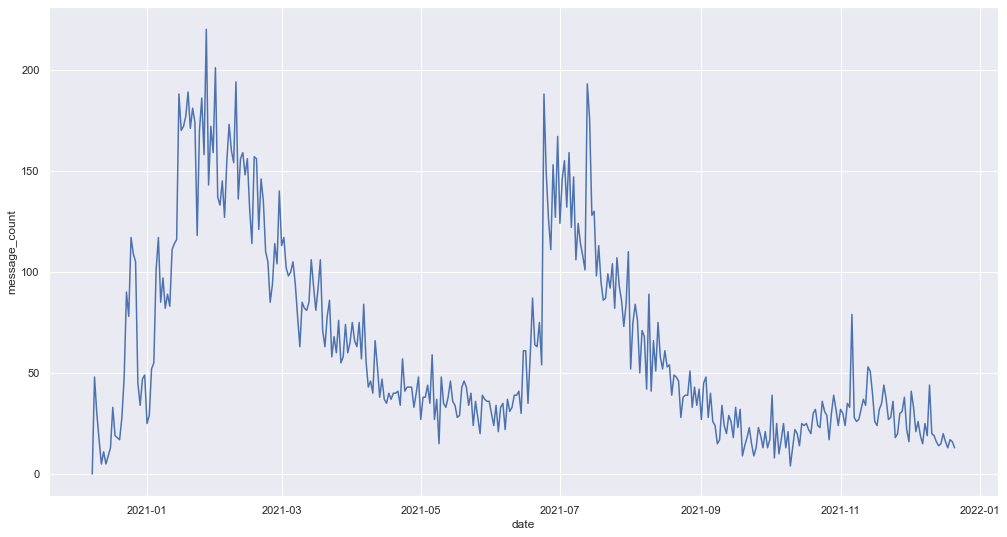

In [2]:
data = pd.read_json('channel_messages.json')
data = data[['date', 'message']]
data.date = data.date.dt.date
data_gr = data.groupby('date', as_index=False).aggregate({'message':"count"})
data_gr.rename(columns={'message':'message_count'}, inplace=True)
sns.lineplot(x=data_gr.date, y=data_gr.message_count)


### Часть 2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательная визуализация. 

In [3]:
data = pd.read_json('channel_messages.json')
data = data[['date','message']]

In [4]:
data.message = data.message.astype(str)
data[['sex','age']] = data.message.str.extract(r'(мужчина|женщина|[МЖмж])[^a-zа-я0-9]*(\d+)', flags=re.IGNORECASE)
data = data[~data.sex.isnull() & ~data.age.isnull()]
data.age = data.age.astype(int)
data = data[data.age<100]
data.sex = data.sex.str.upper()
data.sex = data.sex.str[0]

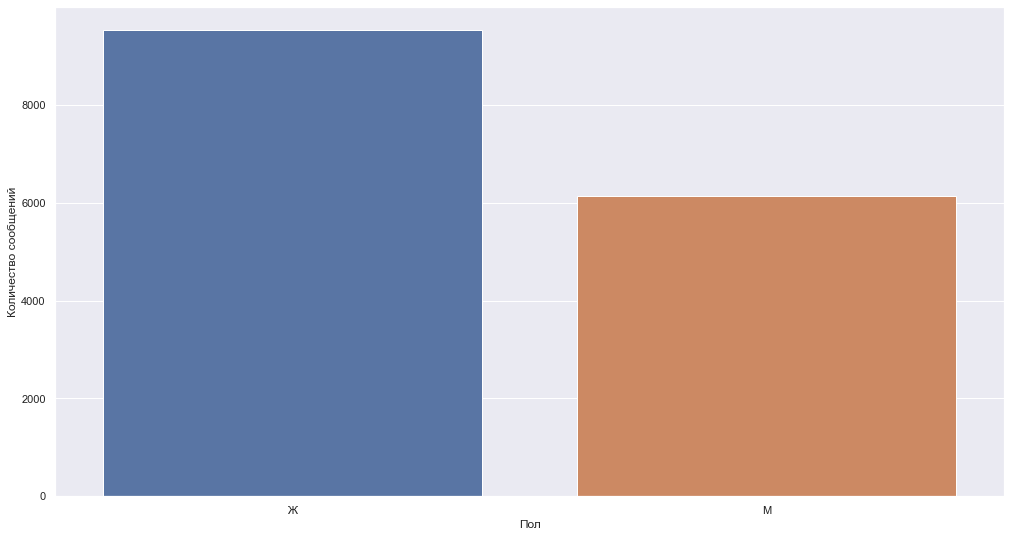

In [5]:
sex_df = data.groupby('sex', as_index=False).aggregate({'message':'count'})
sex_df.rename(columns={'message':'message_count'}, inplace=True)
sns.barplot(x=sex_df.sex, y=sex_df.message_count)
plt.xlabel('Пол')
plt.ylabel('Количество сообщений')
plt.show()

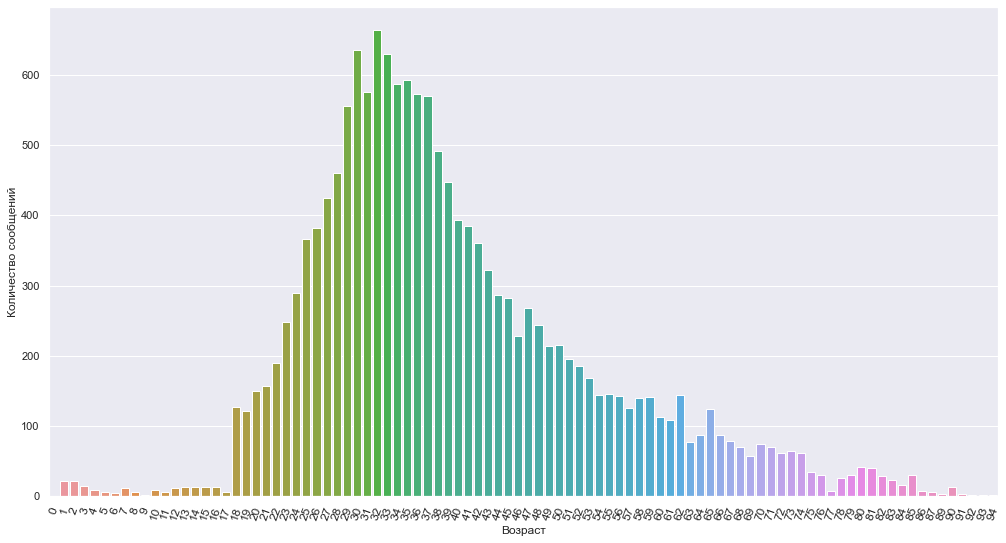

In [6]:
age_df = data.groupby('age', as_index=False).aggregate({'message':'count'})
age_df.rename(columns={'message':'message_count'}, inplace=True)
sns.barplot(x=age_df.age, y=age_df.message_count)
plt.xticks(rotation=70, size=12)
plt.xlabel('Возраст')
plt.ylabel('Количество сообщений')
plt.show()

In [7]:
data['antibodies'] = data.message.str.extract(r'(\d+)[.,]\d+? BAU', flags=re.IGNORECASE)
ab_df = data[~data.antibodies.isnull()]
ab_df.antibodies = ab_df.antibodies.astype(int)
ab_df = ab_df.groupby('age', as_index=False).aggregate({'antibodies':'mean'})

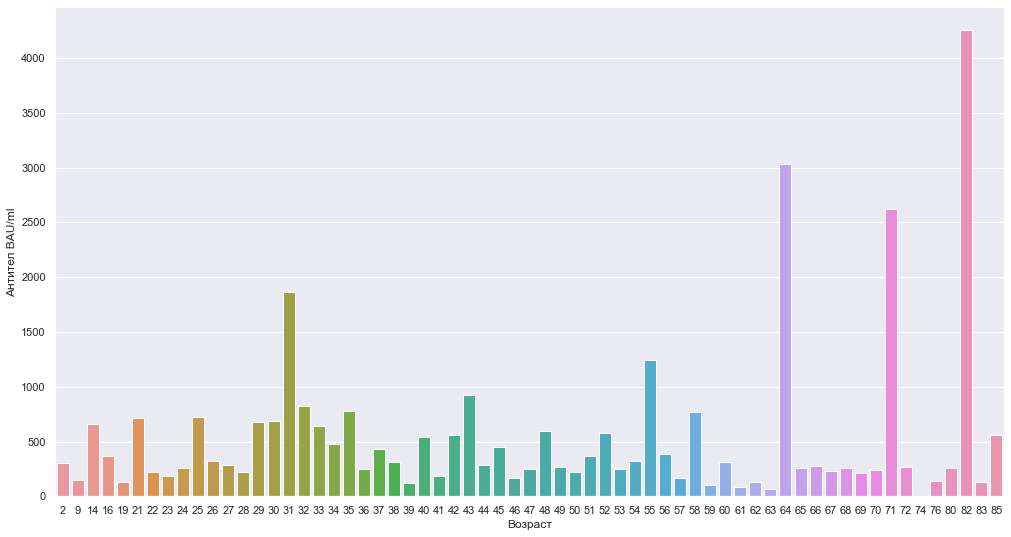

In [8]:
sns.barplot(x=ab_df.age, y=ab_df.antibodies)
plt.xlabel('Возраст')
plt.ylabel('Антител BAU/ml')
plt.show()